In [1]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

In [2]:
from IPython import get_ipython

def is_using_colab() -> bool:
    return "google.colab" in str(get_ipython())

In [3]:
if is_using_colab():
  !pip -q install torchinfo
  import zipfile
  from google.colab import drive
  import os

  # Copy code and datasets zips
  drive.mount('/content/drive')
  !cp -r "/content/drive/MyDrive/Master Thesis/." "."

  # Extract datasets zips
  for zip in os.listdir("Datasets"):
    with zipfile.ZipFile(os.path.join("Datasets", zip), 'r') as zip_ref:
      zip_ref.extractall(os.path.join("Datasets", zip.replace(".zip", "")))
    os.remove(os.path.join("Datasets", zip))

  device = "cuda"

  !mkdir "Experiments"
  experiments_dir = "Experiments"
else:
  device = "cuda"

  experiments_dir = "../05 - Experiments"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from media_utils import plot_img

import os
from tqdm import tqdm

import torch
import time
import cv2

# Dataset Handling


In [5]:
if is_using_colab():
  datasets_path = r"Datasets"
else:
  # datasets_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple"
  # datasets_path = r"C:\datasets"
  datasets_path = r"G:\VM\Shared Folder\preprocess"

# dataset_path = r"G:\VM\Shared Folder\bags\0001.bag"
# EVENTS_TOPIC = "/cam0/events"
# IMAGES_TOPIC = "/cam0/image_raw"

# dataset_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy.bag"
# EVENTS_TOPIC = "/dvs/events"
# IMAGES_TOPIC = "/dvs/image_color"

## Dataset Inspection


### Inspect messages content


In [42]:
from dataset_utils import inspect_dataset
inspect_dataset(dataset_path)

/dvs/events
header: 
  seq: 3504
  stamp: 
    secs: 1553514337
    nsecs:  11357266
  frame_id: ''
height: 260
width: 346
events: 
  - 
    x: 123
    y: 250
    ts: 
      secs: 1553514336
      nsecs: 99136226...

/dvs/image_color
header: 
  seq: 0
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "bgr8"
is_bigendian: 0
step: 1038
data: [0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 8...

/dvs/image_raw
header: 
  seq: 4672
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "mono8"
is_bigendian: 0
step: 346
data: [18, 19, 24, 19, 27, 23, 28, 20, 27, 22...



##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [43]:
from dataset_utils import inspect_message_timestamps
inspect_message_timestamps(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC)


     Topic Name          Event Timestamp
  0) /dvs/image_color    1553514337.0030344
  1) /dvs/events         1553514337.0113573
                         First event timestamp 1553514336.9913623 Last event timestamp 1553514337.0213542
  2) /dvs/image_color    1553514337.0280342
  3) /dvs/events         1553514337.0413592
                         First event timestamp 1553514337.0213573 Last event timestamp 1553514337.0513504
  4) /dvs/image_color    1553514337.0530353
  5) /dvs/events         1553514337.0713603
                         First event timestamp 1553514337.0513632 Last event timestamp 1553514337.0813544
  6) /dvs/image_color    1553514337.0780354
  7) /dvs/image_color    1553514337.1030352
  8) /dvs/events         1553514337.1113732
                         First event timestamp 1553514337.0813613 Last event timestamp 1553514337.1213531
  9) /dvs/image_color    1553514337.1280353
 10) /dvs/events         1553514337.1413844
                         First event timestamp 1553

The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Loading


In [44]:
from dataset_utils import load_bag_as_dataframes
events_df, images_df = load_bag_as_dataframes(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC, max_events=1e6)
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


 43%|████▎     | 426/980 [00:06<00:08, 67.38it/s] 


Events dataframe


,seq,x,y,secs,polarity
0,3504,123,250,1.553514e+09,True
1,3504,195,70,1.553514e+09,True
2,3504,231,92,1.553514e+09,False
3,3504,171,197,1.553514e+09,False
4,3504,181,179,1.553514e+09,False
...,...,...,...,...,...
999995,3620,160,169,1.553514e+09,False
999996,3620,327,0,1.553514e+09,False
999997,3620,236,138,1.553514e+09,False
999998,3620,135,210,1.553514e+09,False


Images dataframe


,seq,secs,width,height,is_bigendian,encoding,step,data
0,0,1.553514e+09,346,260,0,bgr8,1038,"[0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 89, 0..."
1,1,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 81, 88, 0, 81, 89, 0..."
2,2,1.553514e+09,346,260,0,bgr8,1038,"[0, 81, 84, 0, 81, 84, 0, 81, 88, 0, 81, 89, 0..."
3,3,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 86, 88, 0, 86, 89, 0..."
4,4,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 84, 0, 82, 84, 0, 82, 86, 0, 81, 88, 0..."
...,...,...,...,...,...,...,...,...
150,150,1.553514e+09,346,260,0,bgr8,1038,"[0, 79, 84, 0, 79, 84, 0, 84, 88, 0, 88, 89, 0..."
151,151,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 86, 0, 82, 86, 0, 82, 89, 0, 84, 91, 0..."
152,152,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 84, 86, 0, 86, 88, 0..."
153,153,1.553514e+09,346,260,0,bgr8,1038,"[0, 84, 86, 0, 84, 86, 0, 84, 89, 0, 82, 89, 0..."


## Dataset Analysis


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


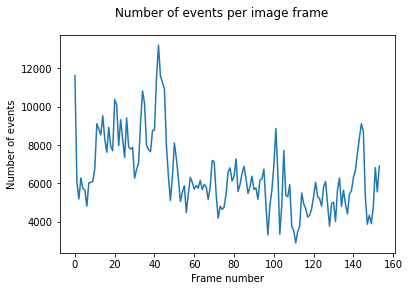

In [45]:
from dataset_utils import plot_number_of_events_per_frame
plot_number_of_events_per_frame(events_df, images_df)

### Check image frames frequency


Average milliseconds: 25.0000, Average fps: 40.00


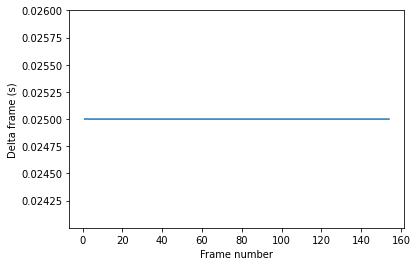

In [46]:
from dataset_utils import plot_image_frames_frequency
plot_image_frames_frequency(images_df)

### Save events for visualization


In [ ]:
from media_utils import save_visual_events

w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_events(events_df, w, h, output_dir)

## Dataset Preparation


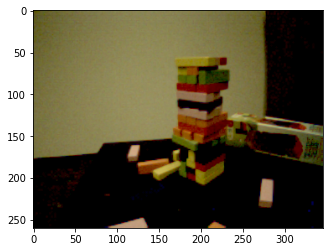

(10, 260, 346)


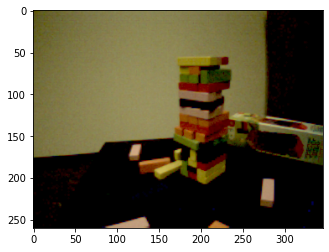

In [49]:
from dataset_utils import dataset_generator_from_batches
batches_path = os.path.join(dataset_path.replace(".bag", ""), "batches")
for batch in dataset_generator_from_batches(batches_path):

    # Old batch format
    (in_, events), out_ = batch
    plot_img(in_)
    print(events.shape)
    plot_img(out_)

    # New batch format
    # events, img = batch
    # print(events.shape)
    # plot_img(img)
    
    break


# Datasets definition


## CED Dataset

In [6]:
train_datasets_names = [
    # "simple_carpet",
    # "simple_color_keyboard_1",
    # "simple_color_keyboard_2",
    # "simple_fruit",
    # "simple_jenga_1",
    # "simple_jenga_destroy",
    # "simple_objects",
    # "simple_rabbits",
    # "simple_wires_1",
    # "simple_wires_2",
    "driving_city_4"
]

valid_datasets_names = [
    # "simple_carpet",
    # "simple_color_keyboard_1",
    # "simple_color_keyboard_2",
    # "simple_fruit",
    # "simple_jenga_1",
    # "simple_jenga_destroy",
    # "simple_objects",
    "simple_rabbits",
    # "simple_wires_1",
    # "simple_wires_2",
]

test_datasets_names = [
    # "simple_carpet",
    # "simple_color_keyboard_1",
    "simple_color_keyboard_2",
    # "simple_fruit",
    "simple_jenga_1",
    # "simple_jenga_destroy",
    # "simple_objects",
    # "simple_rabbits",
    "simple_wires_1",
    # "simple_wires_2",
]

## Synthetic Dataset from DIV2K

In [6]:
train_datasets_names = ["{:04}".format(i) for i in range(1, 8)]

valid_datasets_names = ["{:04}".format(i) for i in range(8, 9)]

test_datasets_names = ["{:04}".format(i) for i in range(9, 9 + 1)]

# PyTorch Dataset and DataLoader

In [7]:
# Check if there is no instersection between train, valid and test dataset
union = set(train_datasets_names).union(set(valid_datasets_names)).union(set(test_datasets_names)) 
sum_of_lengths = sum([len(ds) for ds in [train_datasets_names, valid_datasets_names, test_datasets_names]])
assert len(union) == sum_of_lengths, "Some datasets are in common"

In [8]:
from dataset import CEDDataset, ConcatBatchSampler

TRAIN_DS_PARAMS = {
    "train_datasets_names": train_datasets_names,
    "batch_size": 24,
    "limit_batches": None,
    "num_workers": 4,
    "pin_memory": True,
}

train_datasets = [
    CEDDataset(os.path.join(datasets_path, ds, "batches"), limit=TRAIN_DS_PARAMS["limit_batches"]) for ds in train_datasets_names
]
concat_ds = torch.utils.data.ConcatDataset(train_datasets)

# Do not batch events coming from different datasets
# samplers = [torch.utils.data.RandomSampler(ds) for ds in train_datasets]
# sampler = ConcatBatchSampler(samplers=samplers, batch_size=TRAIN_DS_PARAMS["batch_size"], drop_last=False)
# train_dataloader = torch.utils.data.DataLoader(
#     concat_ds, batch_sampler=sampler,
# )

train_dataloader = torch.utils.data.DataLoader(
    concat_ds,  batch_size=TRAIN_DS_PARAMS["batch_size"], shuffle=True,
    num_workers=TRAIN_DS_PARAMS["num_workers"], pin_memory=TRAIN_DS_PARAMS["pin_memory"]
)


In [9]:
valid_datasets = [
    CEDDataset(os.path.join(datasets_path, ds, "batches"), limit=16) for ds in valid_datasets_names
]
concat_ds = torch.utils.data.ConcatDataset(valid_datasets)
samplers = [torch.utils.data.SequentialSampler(ds) for ds in valid_datasets]
sampler = ConcatBatchSampler(samplers=samplers, batch_size=TRAIN_DS_PARAMS["batch_size"], drop_last=False)
valid_dataloader = torch.utils.data.DataLoader(
    concat_ds, batch_sampler=sampler, num_workers=0,
)

In [10]:
test_datasets = [
    CEDDataset(os.path.join(datasets_path, ds, "batches"), limit=16) for ds in test_datasets_names
]
concat_ds = torch.utils.data.ConcatDataset(test_datasets)
samplers = [torch.utils.data.SequentialSampler(ds) for ds in test_datasets]
sampler = ConcatBatchSampler(samplers=samplers, batch_size=TRAIN_DS_PARAMS["batch_size"], drop_last=False)
test_dataloader = torch.utils.data.DataLoader(
    concat_ds, batch_sampler=sampler, num_workers=0,
)

In [13]:
# Inspect train dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(train_dataloader):

for e, o in tqdm(train_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("train_frames.mp4", frames, 5)

100%|██████████| 41/41 [00:05<00:00,  7.58it/s]


In [14]:
# Inspect valid dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(valid_dataloader):

for e, o in tqdm(valid_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("valid_frames.mp4", frames, 5)

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


In [15]:
# Inspect test dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(test_dataloader):

for e, o in tqdm(test_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("test_frames.mp4", frames, 5)

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


# UNet AutoEncoder Model


In [ ]:
from torchinfo import summary
from models import EventsToImagesUNet

PARAMS = {
    "input_channels": 3 + 10,
}

model = EventsToImagesUNet(PARAMS["input_channels"])
# summary(model, input_size=(4, input_channels, 256, 336), device=device)


## Model Training


In [ ]:
from train import train_unet

PARAMS.update({
    "n_epochs": 3,
    "learning_rate": 0.0001,
    "comment": "",
})
PARAMS.update({"train_dataset_params": TRAIN_DS_PARAMS})

train_unet(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
torch.save(model.state_dict(), "model_thesis.pt")

In [ ]:
# Save input frames as video
from media_utils import save_video_tensors
imgs = []
for batch in tqdm(train_dataloader):
    (input_images, events_tensors), ground_truth_images = batch
    imgs += input_images
save_video_tensors("input_video.mp4", imgs, 30)


In [ ]:
# Save generated frames as video
use_prev_images_as_input = False

imgs = []
for i, batch in enumerate(tqdm(train_dataloader)):
    if use_prev_images_as_input and i != 0:
        input_images = generated_images
    else:
        (input_images, events_tensors), ground_truth_images = batch
    input_images = torch.einsum("bhwc -> bchw", input_images)

    input_tensors = torch.hstack((input_images, events_tensors))
    input_tensors = input_tensors.to(device)

    generated_images = model(input_tensors).cpu().detach()
    generated_images = torch.einsum("bchw -> bhwc", generated_images)

    imgs += generated_images

save_video_tensors("generated_video.mp4", imgs, 30)


In [ ]:
# BS = 1; Seconds for one epoch: 142.36227083206177
# BS = 2; Seconds for one epoch: 132.93124723434448
# BS = 4; Seconds for one epoch: 127.95218682289124
# BS = 8; Seconds for one epoch: 138.49955368041992
# BS = 16; Seconds for one epoch: after 180 seconds it was at 3/10 batches so I stopped it


# Transformer Model


## Model definition


In [ ]:
from models import TransformerModel

PARAMS = {
    "input_shape": (336, 256, 3),
    "encoding_size": 512,
    "heads": 4,
    "layers_number": 2,
}

model = TransformerModel(PARAMS["input_shape"], PARAMS["encoding_size"], PARAMS["heads"], PARAMS["layers_number"])

## Model Training


In [ ]:
from train import train_transformer

PARAMS.update({
    "n_epochs": 3,
    "learning_rate": 0.0001,
    "comment": "",
})
PARAMS.update({"train_dataset_params": TRAIN_DS_PARAMS})

train_transformer(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
# Save model
torch.save(model.state_dict(), "transformer.pt")

In [ ]:
# Load Model
model.load_state_dict(torch.load("transformer.pt"))

# Autoencoder Model

In [ ]:
from models import EventEncoder, EventDecoder, EventAutoEncoder
from torchinfo import summary

PARAMS = {
    "n_filters": [16, 16, 32, 32],
    "output_shape": (336, 256, 1),
}

ee = EventEncoder(n_filters=PARAMS["n_filters"])
ed = EventDecoder(output_shape=PARAMS["output_shape"], n_filters=PARAMS["n_filters"][::-1])
eae = EventAutoEncoder(ee, ed)

# summary(eae, input_size=(64, 1, 256, 336), device=device)

In [ ]:
from train import train_autoencoder

PARAMS.update({
    "n_epochs": 2,
    "learning_rate": 0.0001,
    "comment": ""
})
PARAMS.update({"train_dataset_params": TRAIN_DS_PARAMS})

train_autoencoder(eae, device, concat_ds, PARAMS, log_path=experiments_dir, save_best_model=True)

In [ ]:
# Save model
torch.save(eae.state_dict(), "eae.pt")

In [ ]:
# Load model
eae.load_state_dict(torch.load("eae.pt"))

# Event Encoder Transformer Model

In [ ]:
from models import EventEncoderTransformer
from torchinfo import summary

PARAMS = {
    "output_shape": (336, 256, 3),
    "encoding_size": 336,
    "heads": 4,
    "layers_number": 6
}

# The model is going to use the previous AutoEncoder, so be sure to use a pre-trained version of it

model = EventEncoderTransformer(
    output_shape=PARAMS["output_shape"], 
    encoder=eae.encoder, 
    encoding_size=PARAMS["encoding_size"], 
    heads=PARAMS["heads"], 
    layers_number=PARAMS["layers_number"]
)

# summary(model, input_size=(4, 10, 256, 336))


In [ ]:
from train import train_transformer

PARAMS.update({
    "n_epochs": 300,
    "learning_rate": 0.0001,
    "comment": ""
})
PARAMS.update({"train_dataset_params": TRAIN_DS_PARAMS})

train_transformer(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
# Save model
torch.save(model.state_dict(), "model_tae.pt")

In [ ]:
# Load model
model.load_state_dict(torch.load("model_tae.pt"))

# ViT-like Model

In [11]:
# Clean VRAM
del model
torch.cuda.empty_cache()
import gc
gc.collect()

NameError: name 'model' is not defined

In [12]:
from models.transformer import VisionTransformer
from torchinfo import summary

PARAMS = {
    "input_shape": (10, 128, 128),
    "patch_size": (64, 64),
    "encoding_size": 256,
    "heads": 4,
    "layers_number": 3,
    "use_linear_proj": True
}

model = VisionTransformer(PARAMS["input_shape"], PARAMS["patch_size"], PARAMS["encoding_size"], PARAMS["heads"], PARAMS["layers_number"], PARAMS["use_linear_proj"])

# summary(model, input_size=(4, 10, 256, 256))


Epoch 1/200 Step 41/41 Mean Loss: 0.05303 Elapsed Seconds: 25s - Valid Loss: 0.09020
Epoch 2/200 Step 41/41 Mean Loss: 0.03843 Elapsed Seconds: 5s - Valid Loss: 0.08271
Epoch 3/200 Step 41/41 Mean Loss: 0.03921 Elapsed Seconds: 5s - Valid Loss: 0.08296
Epoch 4/200 Step 41/41 Mean Loss: 0.02563 Elapsed Seconds: 5s - Valid Loss: 0.08301
Epoch 5/200 Step 41/41 Mean Loss: 0.03313 Elapsed Seconds: 5s - Valid Loss: 0.09253
Epoch 6/200 Step 41/41 Mean Loss: 0.03301 Elapsed Seconds: 5s - Valid Loss: 0.08551
Epoch 7/200 Step 41/41 Mean Loss: 0.02303 Elapsed Seconds: 5s - Valid Loss: 0.08794
Epoch 8/200 Step 41/41 Mean Loss: 0.01923 Elapsed Seconds: 5s - Valid Loss: 0.08716
Epoch 9/200 Step 41/41 Mean Loss: 0.01993 Elapsed Seconds: 5s - Valid Loss: 0.08500
Epoch 10/200 Step 41/41 Mean Loss: 0.02173 Elapsed Seconds: 5s - Valid Loss: 0.08193
Epoch 11/200 Step 41/41 Mean Loss: 0.02047 Elapsed Seconds: 5s - Valid Loss: 0.08521
Epoch 12/200 Step 41/41 Mean Loss: 0.01903 Elapsed Seconds: 5s - Valid Lo

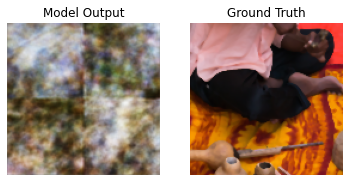

In [13]:
from train import train_vit

PARAMS.update({
    "n_epochs": 200,
    "learning_rate": 0.0002,
    "comment": ""
})
PARAMS.update({"train_dataset_params": TRAIN_DS_PARAMS})

train_vit(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True, save_imgs_after_n_epochs=10, save_times=True)

In [ ]:
# Save model
torch.save(model.state_dict(), "model_vit.pt")

In [ ]:
# Load model
model.load_state_dict(torch.load("model_vit.pt"))

# Evaluation

In [ ]:
# Save video results on train and test set
from media_utils import save_predicted_video
save_predicted_video(model, device, train_dataloader, "train_prediction.mp4")
save_predicted_video(model, device, test_dataloader, "test_prediction.mp4")

In [12]:
# Save events + image visualization
from media_utils import bgr_to_rgb
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
out = cv2.VideoWriter("train_with_img.mp4", fourcc, 30, (336 * 2, 256))

for (img_in, events), img_out in tqdm(train_dataloader):
    for i, batch in enumerate(events):
        img = img_out[i]
        for bin_ in batch:
            bin_ = torch.repeat_interleave(bin_.reshape(256, 336, 1), 3, dim=2)
            frame = cv2.cvtColor(
                (bin_ * 255).numpy().astype(np.uint8), cv2.COLOR_RGB2BGR
            )
            frame = np.hstack((frame, bgr_to_rgb((img * 255).numpy()).astype(np.uint8)))
            out.write(frame)

out.release()


100%|██████████| 74/74 [00:48<00:00,  1.52it/s]


In [ ]:
from media_utils import plot_square

# Eval on train
model.eval()
eval_events = []

for train_ds in train_datasets:
  (in_img, events), out_img = next(iter(train_ds))
  events = events[:, :256, :256]
  eval_events.append(torch.tensor(events.reshape(1, 10, 256, 256)))

results = [model(ev[:1].to(device)) for ev in eval_events]
results = [np.einsum("bchw -> hwc",res.detach().cpu()) for res in results]
plot_square(results, train_datasets_names, size=5)

In [ ]:
from media_utils import plot_square

# Eval on test
model.eval()
eval_events = []

for test_ds in test_datasets:
  (in_img, events), out_img = next(iter(test_ds))
  events = events[:, :256, :256]
  eval_events.append(torch.tensor(events.reshape(1, 10, 256, 256)))

random_tensor = torch.tensor(np.random.rand(1, 10, 256, 256).astype(np.float32))
eval_events.append(random_tensor)

results = [model(ev[:1].to(device)) for ev in eval_events]
results = [np.einsum("bchw -> hwc",res.detach().cpu()) for res in results]
plot_square(results, test_datasets_names + ["Random tensor"], size=5)

# Metadata parsing

In [ ]:
import json

metadata_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\2022-08-19 14-03-31 2000\metadata.json"
with open(metadata_path, encoding="utf8") as f:
    data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

print("Number of epochs:", len(data["epochs"]))
train_loss = [epoch["train_loss"] for epoch in data["epochs"]]
valid_loss = [epoch["valid_loss"] for epoch in data["epochs"]]
plt.plot(range(len(data["epochs"])), train_loss, color="blue", label="Training Loss")
# plt.plot(range(len(data["epochs"])), valid_loss, color="orange", label="Valid loss")
plt.legend()
plt.show()

# Tests

In [7]:
from dataset_utils import inspect_events_bag

folder = r"G:\VM\Shared Folder\bags"
# for bag in os.listdir(folder):
    # bag_path = os.path.join(folder, bag)
    # inspect_events_bag(bag_path, bag + ".mp4", "/cam0/events", "/cam0/image_raw", 3)

In [12]:
bag_path = os.path.join(folder, "0001.bag")

import rosbag
with rosbag.Bag(bag_path) as b:
    types, topics = b.get_type_and_topic_info()
    print(topics)
    # for topic, msg, _ in b.read_messages():
    #     print(str(msg)[:500])
    #     data = msg.data
    #     break

{'/cam0/events': TopicTuple(msg_type='dvs_msgs/EventArray', message_count=1458, connections=1, frequency=323.7198256704356), '/cam0/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=141, connections=1, frequency=28.581411650212246)}


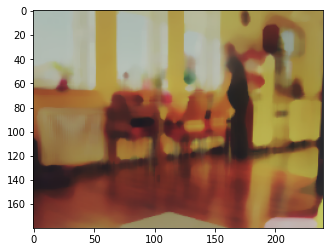

In [19]:
from media_utils import image_from_buffer, bgr_to_rgb
img = image_from_buffer(data, msg.width, msg.height, 3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = bgr_to_rgb(img)
plt.imshow(img)